# 构建一个好的训练集---数据预处理

数据的质量和包含的有用信息量是决定一个机器学习算法能够学多好的关键因素。因此，我们在训练模型前评估和预处理数据显得至关重要。在本章，我们要讨论必不可少的预处理技术，能够帮助我们构建更好的机器学习模型。

本章涉及的主题：
* 移除数据集中的缺失值
* 将分类(category)数据转型，能够被机器学习算法处理
* 特征选择

## 处理缺失值

现实中的数据总是存在或多或少的缺失值现象。原因多种多样，可能是数据收集阶段发生错误，也可能数据调研阶段某些选项没有被填写。不论是什么原因造成的缺失值，我们都统一将其看做空格或者用NaN(Not a Number)表示的占位符。


不幸地是，大多数计算工具不能处理缺失值，即使我们忽略缺失值也不能产生预测结果。因此，我们必须认真对待缺失值问题。在讨论处理缺失值的方法之前，我们先创建一个例子，以便更好地理解缺失值问题：

In [1]:
from io import StringIO

import pandas as pd

In [2]:
csv_data = '''A, B, C, D
              1., 2., 3., 4.
              5., 6.,, 8.
              0., 11., 12.,'''

In [3]:
csv_data = unicode(csv_data)

In [4]:
df = pd.read_csv(StringIO(csv_data))

In [5]:
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN



上面的代码，我们创建了一个csv格式的变量csv_data, 然后读入DataFrame对象，注意其中两个缺失值被NaN替代了。

如果DataFrame对象包含的数据很多，人工来查找NaN就不现实了。我们可以使用isnull方法来返回一个值为布尔类型的DataFrame，判断每个元素是否缺失，如果元素缺失，值为True。然后使用sum方法，我们就能得到DataFrame中每一列的缺失值个数，还是看代码理解吧：

In [6]:
df.isnull().sum()

A     0
 B    0
 C    1
 D    1
dtype: int64


现在我们知道如果统计DataFrame每一列中的缺失值个数。下一节我们学习几种处理缺失值的策略。


**Note** 虽然scikit-learn和NumPy数组结合的很方便，但是预处理时还是推荐使用pandas的DataFrame格式而非NumPy数组。由DataFrame对象得到NumPy数组很方便，直接通过values属性即可，然后就可以用sklearn中的算法了：


In [7]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [ 0., 11., 12., nan]])

 ## 消除带有缺失值的特征或样本

处理缺失值最简单的手段无疑是直接将带有缺失值的特征(列)或样本(行)从数据集中去掉。去掉行可以通过dropna方法：

In [8]:
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


去掉列同样用dropna方法，只不过将参数axis设置为1：

In [9]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,0.0,11.0


dropna方法包含多个参数：

In [10]:
# 只去掉所有值均为NaN的行
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,0.0,11.0,12.0,NaN


In [11]:
# 去掉非缺失值小于4个的行
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0



虽然移除缺失值的操作很简单，但是这样做的缺点也很明显，比如，如果每一行都有一个缺失值，那整个数据集都被移除了。或者移除了过多的特征。

下一节我们学习处理缺失值真正常用的做法：插入法(interpolation)。









## 改写缺失值

用移除法处理缺失值的缺点很明显，过于暴力，会丢掉很多数据信息。怎样保留那些非缺失值数据的同时处理缺失值呢？这就是插入法，用一个估计值来替代缺失值。最常用的是平均估计法，即用整个特征列的平均值代替这一列的缺失值。

使用sklearn中的Imputer类能很容易实现此方法：

In [12]:
from sklearn.preprocessing import Imputer

In [13]:
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)

In [14]:
imputed_data = imr.transform(df.values)

In [15]:
print(df.values)
print('-------------------------------')
print(imputed_data)

[[ 1.  2.  3.  4.]
 [ 5.  6. nan  8.]
 [ 0. 11. 12. nan]]
-------------------------------
[[ 1.   2.   3.   4. ]
 [ 5.   6.   7.5  8. ]
 [ 0.  11.  12.   6. ]]


先计算每一列的平均值，然后用相应列的平均值来替换NaN。如果将参数axis=0改为axis=1，则会计算每个样本的所有特种的平均值。参数strategy的其他取值包括median和most_frequent。most_frequent对于处理分类数据类型的缺失值很有用。











## 理解sklearn中estimator的API

上一节我们调用了sklearn中Imputer类来处理缺失值。Imputer属于sklearn中所谓的transformer类，专门用于数据转换。此类estimator的两个必不可少的方法是fit和transform。fit方法用于从训练集中学习模型参数，transform用学习到的参数转换数据。

任何要进行转换的数据的特征维度必须和fit时的数据特征维度相同。

下图演示了fit和transform的过程：


![](https://ooo.0o0.ooo/2016/06/22/576a5b856e73c.png)




我们在第三章用到的各类分类器属于sklearn中的estimator，它的API和transformer非常像。Estimator还有一个predict方法，大部分也含有transform方法。同样Estimator含有fit方法来学习模型参数。只不过不同的是，在监督学习时，我们还像fit方法提供每个样本的类别信息。

![](https://ooo.0o0.ooo/2016/06/22/576a5cc2bd8b0.png)

( 图中应该是est.fit(X_train,y_train))












## 处理分类数据



目前为止，我们处理的都是数值型变量。但是真实世界的数据集通常都含有分类型变量(categorical value)的特征。当我们讨论分类型数据时，我们不区分其取值是否有序。比如T恤尺寸是有序的，因为XL>L>M。而T恤颜色是无序的。



在讲解处理分类数据的技巧之前，我们先创建一个新的DataFrame对象：



In [16]:
df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                  ['red', 'L', 13.5, 'class2'],
                  ['blue', 'XL', 15.3, 'class1']])

In [17]:
df.columns = ['color', 'size', 'price', 'classlabel']

In [18]:
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1




上面创建的数据集含有无序特征(color)，有序特征(size)和数值型特征(price)。最后一列存储的是类别。在本书中类别信息都是无序的。


### 映射有序特征



为了保证学习算法能够正确解释有序特征(ordinal feature)，我们需要将分类型字符串转为整型数值。不幸地是，并没有能够直接调用的方法来自动得到正确顺序的size特征。因此，我们要自己定义映射函数。在接下来的简单的示例，假设我们知道特征取值间的不同，比如 XL=L+1=M+2。



In [19]:
size_mapping = {
    'XL': 3,
    'L': 2,
    'M': 1
}

In [20]:
df['size'] = df['size'].map(size_mapping)

In [21]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1



如果我们还想将整型变量转换回原来的字符串表示，我们还可以定义一个反映射字典 inv_size_mapping={v: k for k, v in size_mapping.items()}。


### 对类别进行编码



许多机器学习库要求类别是整型数值。虽然sklearn中大部分Estimator都能自动将类别转为整型，我还是建议大家手动将类别进行转换。对类别进行编码，和上一节中转化序列特征很相似。但不同的是类别是无序的，所以我们可以从0开始赋整数值:


In [22]:
import numpy as np

In [23]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}

In [24]:
class_mapping

{'class1': 0, 'class2': 1}

接下来我们可以利用映射字典对类别进行转换：

In [25]:
df['classlabel'] = df['classlabel'].map(class_mapping)

In [26]:
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


得到整型类别值，也可以用映射字典转为原始的字符串值：

In [27]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}

In [28]:
df['classlabel'] = df['classlabel'].map(inv_class_mapping)

In [29]:
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


上面是我们自己手动创建的映射字典，sklearn中提供了LabelEncoder类来实现类别的转换：

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
class_le = LabelEncoder()

In [32]:
y = class_le.fit_transform(df['classlabel'].values)

In [33]:
y

array([0, 1, 0])

fit_transform方法是fit和transform两个方法的合并。我们还可以调用inverse_transform方法得到原始的字符串类型值：


In [34]:
class_le.inverse_transform(y)

/Users/lj/.pyenv/versions/2.7.12/lib/python2.7/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['class1', 'class2', 'class1'], dtype=object)

### 对离散特征进行独热编码

前面一节我们使用字典映射来转化有序特征，由于sklearn中Estimator把类型信息看做无序的，我们使用LabelEncoder来进行类别的转换。而对于无序的离散特征，我们也可以使用LabelEncoder来进行转换：


In [35]:
X = df[['color', 'size', 'price']].values

In [36]:
color_le = LabelEncoder()

In [37]:
X[:, 0] = color_le.fit_transform(X[:, 0])

In [38]:
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

现在我们将无序离散特征转换为整型了，看起来下一步就是直接训练模型了。如果你这样想，恭喜你，你犯了一个很专业的错误。在处理分类型数据(categorical data)时，这是很常见的错误。你能发现问题所在吗？虽然“颜色”这一特征的值不含有顺序，但是由于进行了以下转换：

![](https://ooo.0o0.ooo/2016/06/22/576b3bb04ba79.png)

学习算法会认为‘green’比‘blue’大，‘red’比‘green’大。而这显然是不正确的，因为本身颜色是无序的！模型错误的使用了颜色特征信息，最后得到的结果肯定不是我们想要的。


那么如何处理无序离散特征呢？常用的做法是**独热编码(one-hot encoding)**。独热编码会为每个离散值创建一个哑特征(dummy feature)。什么是哑特征呢？举例来说，对于‘颜色’这一特征中的‘蓝色’，我们将其编码为[蓝色=1，绿色=0，红色=0]，同理，对于‘绿色’，我们将其编码为[蓝色=0，绿色=1，红色=0]，特点就是向量只有一个1，其余均为0，故称之为one-hot。

在sklearn中，可以调用OneHotEncoder来实现独热编码：

In [39]:
from sklearn.preprocessing import OneHotEncoder

In [40]:
ohe = OneHotEncoder(categorical_features=[0])

In [41]:
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [42]:
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [43]:
ohe.fit_transform(X)

<3x5 sparse matrix of type '<type 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>


在初始化OneHotEncoder时，通过categorical_features参数设置要进行独热编码的列。还要注意的是OneHotEncoder的transform方法默认返回稀疏矩阵，所以我们调用toarray()方法将稀疏矩阵转为一般矩阵。我们还可以在初始化OneHotEncoder时通过参数sparse=False来设置返回一般矩阵。


除了使用sklearn中的OneHotEncoder类得到哑特征，我推荐大家使用pandas中的get_dummies方法来创建哑特征，get_dummies默认会对DataFrame中所有字符串类型的列进行独热编码：

In [44]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


## 将数据集分割为训练集和测试集

本节，我们使用一个新的数据集：Wine。Wine也属于UCI开源数据集，它包含178个样本，每个样本有13维度特征，描述了不同的化学属性。

### Wine 数据集

In [45]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [46]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', '0D280/0D315 of diluted wines', 'Proline']

In [48]:
print("Class labels", np.unique(df_wine['Class label']))

('Class labels', array([1, 2, 3]))


In [49]:
df_wine.head(1)

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,0D280/0D315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065


Wine数据集一共有三个类别：1,2和3.表示三个葡萄品种。


首先将数据集随机分割为训练集和测试集，一种简单的方法是使用sklearn.cross_validation中的train_test_split方法：

In [50]:
from sklearn.cross_validation import train_test_split

In [53]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


解释一下上面的代码： 首先，我们将特征矩阵赋值给X，将类别向量赋值给y，然后调用train_test_split方法随机分割X和y。通过设置test_size=0.3,使得训练集占Wine样本数的70%，测试集占30%。


**Note** 在分割数据集时，如果确定训练集和测试集的大小没有通用的做法，一般我们选择60:40, 70:30或者80:20。对于大数据集，90:10甚至 99:1也是比较常见的。还要注意的是，通过本地验证得到最优模型和参数时，还要在整个数据集(训练集+验证集+测试集)上训练一次，得到最终的模型。

## 统一特征取值范围

特征缩放(feature scaling)是预处理阶段的关键步骤，但常常被遗忘。虽然存在决策树和随机森林这种是少数不需要特征缩放的机器学习算法，但对于大部分机器学习算法和优化算法来说，如果特征都在同一范围内，会获得更好的结果。比如第二章提到的梯度下降法。

特征缩放的重要性可以通过一个简单的示例解释。假设我们有两个特征，一个特征的取值范围是[1,10],另一个特征的取值范围是[1,100000]。我们使用Adaline中的平方误差函数，很明显，权重更新时会主要根据第二维度特征，这就使得在权重更新过程中第一个特征的话语权很小。另一个例子是如果kNN算法用欧氏距离作为距离度量，第二维度特征也占据了主要的话语权。


有两种方法能使不同的特征有相同的取值范围：归一化(normalization)和标准化(standardization)。两种方法还是有必要区分一下的。归一化指的是将特征范围缩放到[0,1]，是最小-最大缩放(min-max scaling)的特例。为了得到归一化结果，我们对每一个特征应用最小-最大缩放，计算公式如下：

$$x_{norm}^{(i)}=\frac{x^{(i)} - x_{min}}{x_{max}-x_{min}}$$


其中，$x_{norm}^{(i)}$是$x^{(i)}$归一化后的结果，$x_{min}$是对应的列特征最小值，$x_{max}$则是最大值。


sklearn中实现了最小-最大缩放，调用MinMaxScaler类即可：



In [55]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
mms = MinMaxScaler()

In [57]:
X_train_norm = mms.fit_transform(X_train)

In [58]:
X_test_norm = mms.transform(X_test)

虽然归一化方法简单，但相对来说，标准化对于大部分机器学习算法更实用。原因是大部分线性模型比如逻辑斯蒂回归和线性SVM在初始化权重参数时，要么选择0要么选择一个接近0的随机数。实用标准化，我们能将特征值缩放到以0为中心，标准差为1，换句话说，标准化后的特征形式服从正态分布，这样学习权重参数更容易。此外，标准化后的数据保持了异常值中的有用信息，使得算法对异常值不太敏感，这一点归一化就无法保证。


标准化的计算公式如下：

$$x_{std}^{(i)}=\frac{x^{(i)}-u_{x}}{\sigma_{x}}$$


此时，$u_{x}$是训练集对应特征列的平均值，$\sigma_{x}$是对应特征列的标准差。

下面一张表使用一个简单的例子，展示了标准化和归一化的区别：
![](https://ooo.0o0.ooo/2016/06/22/576b51a76b9ea.png)


sklearn中提供了StandardScalar类实现列标准化：



In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
stdsc = StandardScaler()

In [61]:
X_train_std = stdsc.fit_transform(X_train)

In [62]:
X_test_std = stdsc.transform(X_test)

**再次强调，StandardScaler只使用训练集fit一次，这样保证训练集和测试集使用相同的标准进行的特征缩放**。



## 选择有意义的特征

如果一个模型在训练集的表现比测试集好很多，那我们就要小心了，模型很可能过拟合了。过拟合意味着模型捕捉了训练集中的特例模式，但对未知数据的泛化能力比较差，我们也说模型此时具有高方差。

模型过拟合的一个原因是对于给定的训练集数据，模型过于复杂，常用的减小泛化误差的做法包括：
* 收集更多的训练集数据
* 正则化，即引入模型复杂度的惩罚项
* 选择一个简单点的模型，参数少一点的
* 降低数据的维度


在上面的一系列做法中，第一条收集更多数据通常不实用。在下一章，我们会学习一个有用的技巧来判断更多的训练集数据是否有帮助。在接下来的章节，我们学习正则化和特征选择的方法来降低过拟合。


### L1正则

会议第三章，我们运用过L2正则来降低模型的复杂度，当时我们定义的L2正则项：


![](https://ooo.0o0.ooo/2016/06/22/576b57f087fe7.png)


除了L2正则，另一个中减低模型复杂度的方法是L1正则(L1 regularization)：

![](https://ooo.0o0.ooo/2016/06/22/576b582456836.png)

L2正则项是权重参数的平方和，而L1正则项是权重参数的绝对值和。相对于L2, L1正则项趋向于得到稀疏特征向量，即很多特征权重参数为0.如果数据集的特征维度很高且特征不相干(极端情况是 不相干的特征维度数目比训练样本数还大)，特征稀疏性是非常有用的。 由于很多特征权重为0，所以，很多人也把L1正则看做特征选择的一种方式。


为了更好地理解L1正则倾向于产生稀疏特征，让我们看一下正则化的几何解释。假设损失函数是差平方损失函数(sum of the squared errors, SSE),且只含有两个权重参数$w_{1}, w_{2}$，易知损失函数是凸函数。对于给定的损失函数，我们的目的是找到损失函数取最小值时对应的权重值，如下图损失函数等高线所示，当($w_{1},w_{2}$)取椭圆中心点时，损失函数值最小：


![](https://ooo.0o0.ooo/2016/06/23/576b8d0681fc4.png)


而正则项是对现在损失函数的惩罚项，它鼓励权重参数取小一点的值，换句话说，正则项惩罚的是大权重参数。

因此，如果增大正则系数$\lambda$的值，也就增大了正则项的威力，也就会导致权重参数变小(趋向于0)，从而也减小了模型对训练数据的依赖。我们在下图画出L2惩罚项：

![](https://ooo.0o0.ooo/2016/06/23/576b8e1a721d3.png)


L2正则项用图上阴影球形表示$w_{1}^{2}+w_{2}^{2}<=\frac{1}{\lambda}$。**正则化后的 新损失函数=原始损失函数+正则项，我们可以换一种思路解释这个公式，新的损失函数还是原始损失函数，我们把正则项看做权重参数的限制条件，也就是说，权重参数的取值范围必须在图中阴影球形内**。如果增大$\lambda$的值，会缩小阴影球形面积。比如，如果$$\lambda$$趋向正无穷，则阴影面积趋向0，权重参数也趋向0.

我们总结一下：我们的目标是最小化原始损失函数和正则项，等价于在原始损失函数基础上增加限制条件，更加偏向于简单模型来减小方差。


现在我们讨论L1正则项和稀疏性。L1正则和刚才讨论的L2正则很像。当然区别还是有的：L1正则是权重参数绝对值的和，我们用一个另行区域表示，如下图所示：



![](https://ooo.0o0.ooo/2016/06/23/576b939fa6338.png)


由于菱形的特点，在和损失函数等高线相交时，最小点很可能落在坐标轴上，这就导致了特征的稀疏性。如果你对这背后的数学感兴趣，推荐阅读 *The Elements of Statistical Learning, Trevor Hastie, Robert Tibshirani, and Friedman, Springer*。


对于sklearn中那些支持L1正则的模型，我们只需要在初始化时用penalty参数设置为L1正则即可：



In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

将L1正则逻辑斯蒂回归应用到标准化后的Wine数据集：

In [65]:
lr = LogisticRegression(penalty='l1', C=0.1)

In [66]:
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
print("Training accuracy: {}".format(lr.score(X_train_std, y_train)))

Training accuracy: 0.983870967742



模型在训练集和测试集上的准确率说明没有过拟合。如果我们调用lr.intercept_属性，可以发现只返回了三个值：


In [68]:
lr.intercept_

array([-0.38378555, -0.15813427, -0.70041216])



由于Wine数据集是多类别数据，所以lr使用了One-vs-Rest(OvR)方法，所以上面三个值分别属于三个模型：第一个模型用类别1 vs 类别2和3；第二个模型用类别2 vs 类别1和3；第三个模型用类别3 vs 类别1和2。


In [69]:
lr.coef_

array([[ 0.28038386,  0.        ,  0.        , -0.02798846,  0.        ,
         0.        ,  0.71018965,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.23572666],
       [-0.64370733, -0.06892275, -0.05715523,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.92712303,
         0.05983122,  0.        , -0.37105833],
       [ 0.        ,  0.06151483,  0.        ,  0.        ,  0.        ,
         0.        , -0.63613533,  0.        ,  0.        ,  0.49813629,
        -0.35820553, -0.5711789 ,  0.        ]])

通过lr.coef_得到权重数组，共三行，每一个类对应一行。每一行有13个参数，对应13个特征。网络输入计算如下：


![](https://ooo.0o0.ooo/2016/06/23/576b9a7bc8c6c.png)

我们可以发现权重向量中有很多0值，这说明L1正则可以作为特征选择的一种手段，得到的模型具有鲁棒性。



最后，我们画出正则路径，即不同正则威力下的不同特征的权重参数：



In [70]:
import matplotlib.pyplot as plt

In [71]:
fig = plt.figure()

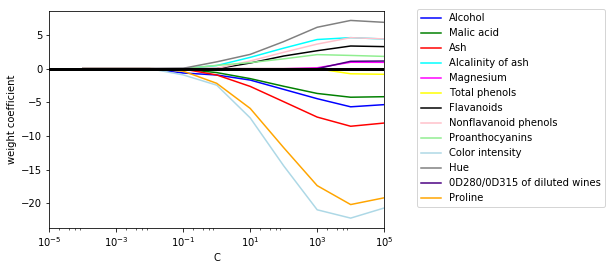

In [73]:
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen', 'lightblue',
         'gray', 'indigo', 'orange']
weights, params = [], []

for c in np.arange(-4, 6, dtype=float):
    lr = LogisticRegression(penalty='l1', C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1], color=color)
    
plt.axhline(0, color='black', linestyle='-', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)
plt.show()

我们可以发现，如果C<0.1,正则项威力很大时，所有特征权重都为0，$C=\frac{1}{\lambda}$。



### 序列特征选择算法

另一种减小模型复杂度和避免过拟合的方法是通过特征选择进行维度降低(dimensionality reduction)，这个方法尤其对非正则模型有用。维度降低有两种做法：特征选择(feature selection)和特征抽取(feature extraction)。

特征选择会从原始特征集中选择一个子集合。特征抽取是从原始特征空间抽取信息，从而构建一个新的特征子空间。本节，我们学习特征选择算法。在下一章，我们会学到不同的特征抽取方法来将数据集压缩到一个低维度特征子空间。


序列特征选择算法属于贪心搜索算法，用于将原始的d维度特征空间降低到k维度特征子空间，其中k<d。

特征选择算法的原理是自动选择一个特征子集，子集中的特征都是和问题最相关的特征，这样能够提高计算效率并且由于溢出了不相干特征和噪音也降低了模型的泛化误差。

一个经典的序列特征选择算法是序列后向选择(sequential backward selection, SBS),它能够降低原始特征维度提高计算效率，在某些情况下，如果模型过拟合，使用SBS后甚至能提高模型的预测能力。


**Note**贪心算法在每一次选择时都会做出局部最优选择，通常产生一个次优全局解，暴力搜索要考虑所有的可能的情况所以会保证得到全局最优解。但由于穷搜的计算复杂度过高，导致其并不是最佳选择。


SBS算法的idea很简单：SBS序列地从原始特征集中移除特征，直到新的特征集数目达到事先确定的值。而在移除特征时，我们需要定义评价函数$J$。一个特征的重要性就用特征移除后的评价函数值表示。我们每一次都把那些评价函数值最大的特征移除，也就是那些对评价函数影响最小的特征去掉。所以，SBS算法有以下4个步骤：


* 1 初始化k=d，其中d是原始特征维度。
* 2 确定那个评价函数最大的特征 $x^{-}=argmax J(X_{k}-x), x\in X_{k}$。
* 3 从$X_{k}$中移除特征$x^{-}$, k=k-1。
* 4 如果k等于事先确定的阈值则终止；否则回到步骤2。



不过，sklearn目前并没有实现SBS算法，好在算法简单，我们可以自己实现：


In [74]:
from itertools import combinations

from sklearn.base import clone
from sklearn.metrics import accuracy_score

In [76]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self

    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        
        return score


在上面的代码中，我们定义了k_features参数来设定想要得到的特征子集数。使用accuracy_score来评估模型在特征子集的表现。在fit方法的while循环内，通过itertools.combination创建特征子集然后对其评估，

现在我们用KNN作为Estimator来运行SBS算法：


In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [78]:
knn = KNeighborsClassifier(n_neighbors=2)

In [79]:
sbs = SBS(knn, k_features=1)

In [80]:
sbs.fit(X_train_std, y_train)

<__main__.SBS instance at 0x116d7a2d8>

虽然SBS的fit方法中有分割数据集的功能，但我们还是为SBS提供了训练集，然后fit方法将其分割为子训练集和子测试集，而这个子测试集被称为验证集(validation dataset)。

SBS算法记录了每一步最优特征子集的成绩，我们画出每个最优特征子集在验证集上的分类准确率：

In [81]:
k_feat = [len(k) for k in sbs.subsets_]

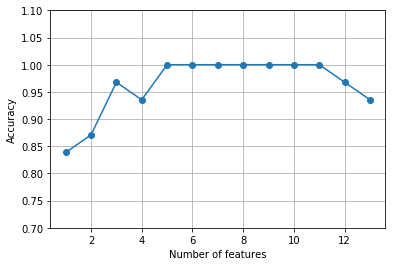

In [82]:
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()


我们可以看到，最开始随着特征数目的减少，分类准确率一直在提高，原因可能是降低了维度诅咒。对于k={5,6,7,8,9,10,11}，分类准确率是100%.

我们将最优的5维度特征打印出来看一下：


In [83]:
k5 = list(sbs.subsets_[8])

In [84]:
print(df_wine.columns[1:][k5])

Index([u'Alcohol', u'Malic acid', u'Alcalinity of ash', u'Hue', u'Proline'], dtype='object')


接下来我们使用整个特征维度来检验KNN模型在测试集的分类准确率：


In [85]:
knn.fit(X_train_std, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [86]:
print("Training accuracy: {}".format(knn.score(X_train_std, y_train)))

Training accuracy: 0.983870967742


In [87]:
print("Test accuracy: {}".format(knn.score(X_test_std, y_test)))

Test accuracy: 0.944444444444


可以看到使用原始的特征集建模，在训练集上分类准确率98%，测试集上分类准确率94%，可能是模型有一丢丢过拟合。

我们再使用最优的5维度特征建模看看：

In [88]:
knn.fit(X_train_std[:, k5], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [89]:
print("Training accuracy: {}".format(knn.score(X_train_std[:, k5], y_train)))

Training accuracy: 0.959677419355


In [90]:
print("Test accuracy: {}".format(knn.score(X_test_std[:, k5], y_test)))

Test accuracy: 0.962962962963


使用不到一半的原始特征，虽然在训练集上分类准确率下降了，但是在测试集上的表现却提高了！并且此时训练集和测试集准确率相差不多，我们很好地降低了过拟合。

**Note** sklearn中提供了很多特征选择算法。包括基于特征参数的递归后向消除法，基于树方法提供的特征重要性的特征选择法和单变量统计检验。具体的可以看sklearn文档。

## 利用随机森林评估特征重要性

在前面一节，你学习了如何利用L1正则将不相干特征变为0，使用SBS算法进行特征选择。另一种从数据集中选择相关特征的方法是利用随机森林。

随机森林能够度量每个特征的重要性，我们可以依据这个重要性指标进而选择最重要的特征。sklearn中已经实现了用随机森林评估特征重要性，在训练好随机森林模型后，直接调用feature_importances属性就能得到每个特征的重要性。

下面用Wine数据集为例，我们训练一个包含10000棵决策树的随机森林来评估13个维度特征的重要性(第三章我们就说过，对于基于树的模型，不必对特征进行标准化或归一化):



In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
feat_labels = df_wine.columns[1:]

In [93]:
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

In [94]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [95]:
importances = forest.feature_importances_

In [96]:
indices = np.argsort(importances)[::-1]

In [97]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1, 30, feat_labels[f], importances[indices[f]]))

 1) Alcohol                        0.182483
 2) Malic acid                     0.158610
 3) Ash                            0.150948
 4) Alcalinity of ash              0.131987
 5) Magnesium                      0.106589
 6) Total phenols                  0.078243
 7) Flavanoids                     0.060718
 8) Nonflavanoid phenols           0.032033
 9) Proanthocyanins                0.025400
10) Color intensity                0.022351
11) Hue                            0.022078
12) 0D280/0D315 of diluted wines   0.014645
13) Proline                        0.013916


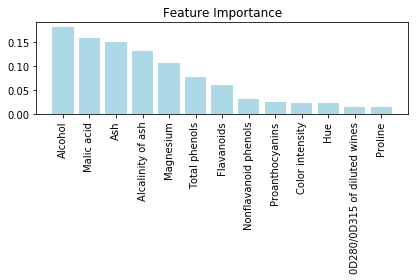

In [98]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
       importances[indices],
       color='lightblue',
       align='center')
plt.xticks(range(X_train.shape[1]),
          feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

我们可以得出结论：‘Alcohol’是最能区分类别的特征。有趣地是，重要性排名前三的特征也在SBS的最优5特征子集中。

sklearn的随机森林实现，包括一个transform方法能够基于用户给定的阈值进行特征选择，所以如果你要用RandomFroestClassifier作为特征选择器，这就很easy了。举个例子：设置阈值为0.15，会选择出三个维度特征，Alcohol、Malic acid和Ash。

In [99]:
X_selected = forest.transform(X_train, threshold=0.15)

/Users/lj/.pyenv/versions/2.7.12/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/lj/.pyenv/versions/2.7.12/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [100]:
X_selected.shape

(124, 3)

## 总结

本章最开始我们介绍了如何处理缺失值。在训练模型之前，我们必须保证已经正确处理分类数据。


此外，我们简单讨论了L1正则，它可以帮助我们降低模型复杂度来避免过拟合。另一种移除不相关特征的方法是使用序列特征选择算法来选择有意义的特征。


在下一章，你将会学到另一类降维的方法：特征抽取。它能够将特征压缩到一个低维度子空间而不是移除某些特征。



